# 导入包

In [6]:
import os
import numpy as np
import pandas as pd

from astropy import units as u
from astropy.table import Table, Column, MaskedColumn
from astropy.time import Time, TimeDelta
from astropy.coordinates import SkyCoord, Distance, GCRS
from astropy.wcs import WCS
from astropy.io import fits, ascii
from astroquery.vizier import Vizier
import itertools

from collections import Counter
import matplotlib.pyplot as plt

import pickle
import function

## 函数定义

In [7]:
def bins_divide(data, relative_data, bins_num):
    bins_interval = np.linspace(np.min(data) * 0.99, max(data) * 1.01, bins_num + 1)
    bins_center_interval = (bins_interval[:-1] + bins_interval[1:]) / 2

    bins_dis = []
    bins_mean = []
    bins_id_data = np.digitize(data, bins_interval) - 1

    for i in range(0, bins_num):
        index_divide = bins_id_data == i
        bins_dis.append(np.std(relative_data[index_divide]))
        bins_mean.append(np.mean(relative_data[index_divide]))

    return bins_center_interval, bins_mean, bins_dis

# Source-Extractor处理和结果

## 文件路径和信息

In [8]:
CONFIG_PATH = "/home/fangwf/software/miniconda3/envs/csst_mci/lib/python3.11/site-packages/csst_mci_astrometry/data/"

band = "C2"
band_short = "r"
band_short_capital = "R"
band_index = 2
day = "230614"
obs_index = "08"
unkonw_index = "01"
exp_time = 1500

obs_info = {"01": "20230614054340_20230614054840", "02" :"20240119021141_20240119021641", "03": "20240119021742_20240119022242", "04": "20240119022342_20240119022842", "05": "20240119022941_20240119023441"}

img_path: str = f'/home/fangwf/MCI_SimData/{day}/L1/ins/CSST_MCI_{band}_STAR_{obs_info[unkonw_index]}_202000000{unkonw_index}_{obs_index}_L0_VER.fits'


In [9]:
img_path

'/home/fangwf/MCI_SimData/230614/L1/ins/CSST_MCI_C2_STAR_20230614054340_20230614054840_20200000001_08_L0_VER.fits'

In [10]:
hdu_img = fits.open(img_path)
hdu_img_header = hdu_img[1].header
pointing_ra, pointing_dec = hdu_img_header["CRVAL1"], hdu_img_header["CRVAL2"]
CD1_1, CD1_2, CD2_1, CD2_2 = hdu_img_header["CD1_1"], hdu_img_header["CD1_2"], hdu_img_header["CD2_1"], hdu_img_header["CD2_2"]
x_ref, y_ref = hdu_img_header["CRPIX1"], hdu_img_header["CRPIX2"]

print(f"reference point pixel, {x_ref}, {y_ref}")
print(f"reference point celestical, {pointing_ra}, {pointing_dec}")

reference point pixel, 4607.5, 4615.5
reference point celestical, 260.0445206737792, -0.01074148799459571


## Source-Extractor结果

### 读取已有或直接处理fits图像

In [11]:
# 读取已有结果文件
fp_out_sext = f"/home/fangwf/code/csst_mci_multiband_0614/sext_out/{band}_{band_short}_{exp_time}_out.fits"
hdu_list =  fits.open(fp_out_sext)
hdu_list.info()
sext_out_filter = Table(hdu_list[2].data)

sext_out_filter

Filename: /home/fangwf/code/csst_mci_multiband_0614/sext_out/C2_r_1500_out.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU       4   ()      
  1  LDAC_IMHEAD    1 BinTableHDU     12   1R x 1C   [12000A]   
  2  LDAC_OBJECTS    1 BinTableHDU    163   2954R x 39C   [1E, 1E, 1D, 1D, 1J, 1J, 1J, 1J, 1D, 1D, 1D, 1D, 1D, 1D, 1D, 1D, 1D, 1D, 1E, 1E, 1E, 1E, 1E, 1E, 1E, 1E, 1E, 1E, 1E, 1E, 1E, 1E, 1E, 1E, 1E, 1J, 1E, 1I, 1E]   


X_IMAGE,Y_IMAGE,XWIN_IMAGE,YWIN_IMAGE,XMIN_IMAGE,XMAX_IMAGE,YMAX_IMAGE,YMIN_IMAGE,ALPHA_J2000,DELTA_J2000,ALPHAWIN_J2000,DELTAWIN_J2000,X_WORLD,Y_WORLD,X2WIN_IMAGE,Y2WIN_IMAGE,ERRX2WIN_IMAGE,ERRY2WIN_IMAGE,AWIN_IMAGE,BWIN_IMAGE,ERRAWIN_IMAGE,ERRBWIN_IMAGE,THETAWIN_IMAGE,ERRTHETAWIN_IMAGE,CXXWIN_IMAGE,CYYWIN_IMAGE,ELLIPTICITY,AWIN_WORLD,BWIN_WORLD,ERRAWIN_WORLD,ERRBWIN_WORLD,FLUX_AUTO,FLUXERR_AUTO,MAG_AUTO,MAGERR_AUTO,ISOAREAF_IMAGE,FWHM_IMAGE,FLAGS,BACKGROUND
float32,float32,float64,float64,int32,int32,int32,int32,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,int32,float32,int16,float32
3747.4197,687.5048,3751.8278381173404,688.455968327293,3618,3927,973,546,260.05646623619015,-0.06529695902577273,260.0564050115202,-0.06528374833261186,260.05646623619015,-0.06529695902577273,974.3450617148663,930.9480966018054,2.8494716376898714e-06,2.76525208030542e-06,31.328773,30.394096,0.0016913493,0.0016595365,20.607971,18.90516,0.0010267394,0.0010746017,0.04993528,0.0004351216,0.00042213988,2.3490948e-08,2.3049099e-08,848978240.0,24244.09,-22.32224,3.101267e-05,76265,269.5704,5,11456.366
3545.3882,275.0352,3545.5591542999077,274.9592674975596,3443,3642,380,150,260.0592722304125,-0.07102569706482274,260.0592698550345,-0.07102675134590934,260.0592722304125,-0.07102569706482274,26.94518335297104,25.272581561207982,2.867733790024698e-06,2.7404026463936223e-06,5.2481484,4.967364,0.0017184553,0.0016294317,-27.164803,-32.354145,0.037186515,0.03964761,0.042073786,7.289091e-05,6.899108e-05,2.386742e-08,2.263097e-08,26945172.0,4624.039,-18.576202,0.00018636757,22210,40.455246,6,907.9128
7290.1484,146.05795,7290.144866541901,146.08498371939643,7244,7330,187,104,260.0072616659517,-0.0728170323159712,260.00726171432893,-0.0728166568699538,260.0072616659517,-0.0728170323159712,3.158944172336293,2.6914788420181797,2.9967732806016593e-06,2.658363689692396e-06,1.7842373,1.633071,0.0017359122,0.0016253449,-12.593736,-12.207705,0.317012,0.37207174,0.018594027,2.4781044e-05,2.2681514e-05,2.4109863e-08,2.2574207e-08,3209702.8,1665.3083,-16.266163,0.0005634556,4502,13.694991,7,877.3007
7274.3438,145.74739,7274.136760205689,145.6454986640117,7242,7292,158,104,260.007481176536,-0.0728213458498716,260.007484049094,-0.07282276100382663,260.007481176536,-0.0728213458498716,1.1773544083022938,0.8109787869347173,3.6437353734938658e-06,2.653319363094523e-06,1.0850692,0.9005321,0.0019088585,0.0016288996,-0.43052578,0.13306758,0.8493687,1.2330877,0.14452714,1.507039e-05,1.2507373e-05,2.6511897e-08,2.2623574e-08,996277.0,894.07544,-14.995951,0.0009745943,587,18.892025,7,877.47595
3500.028,20.886196,3499.9478110651667,20.780061874457363,3495,3506,26,16,260.0599022316299,-0.07455553953178913,260.0599033461827,-0.07455701361533851,260.0599022316299,-0.07455553953178913,0.5508918785512529,0.440129611885302,7.819230315213393e-05,7.428677980242824e-05,0.7451688,0.6601098,0.0088960435,0.008563848,11.041844,23.836725,1.819026,2.276799,0.07969749,1.0349559e-05,9.16818e-06,1.2355605e-07,1.1894221e-07,28261.143,272.68033,-11.1279745,0.010478375,102,1.9394599,0,872.18225
780.38794,18.736906,780.2284219179859,18.612116066949554,776,785,23,15,260.09767500438994,-0.0745853613235641,260.0976772202624,-0.07458709452371279,260.09767500438994,-0.0745853613235641,0.5287699463511442,0.4184091989747877,0.0001862720747413142,0.0001818610271764442,0.7299678,0.64368176,0.013741587,0.013390365,10.69623,31.213078,1.8951844,2.3950634,0.070509136,1.0138425e-05,8.940011e-06,1.90855e-07,1.8597709e-07,14157.861,243.77155,-10.377494,0.018698862,77,2.2716131,0,872.081
5811.3965,14.68092,5811.263515407385,14.483765511872276,5805,5818,21,9,260.027799887959,-0.07464172332424801,260.0278017327501,-0.07464446157646508,260.027799887959,-0.07464172332424801,0.5659138629236337,0.4433564546974128,4.20487020960796e-05,3.909364067402206e-05,0.7534

# Gaia参考星获取

## 读取已有或直接网络下载

In [12]:
fp_ref = "/home/fangwf/code/csst_mci_multiband_0614/sext_out/star_cat_230614.fits"
ref_filter = Table(fits.open(fp_ref)[1].data)
ref_filter

ra,dec,magu,magg,magr,magi,magz,Pos_X,Pos_Y
float64,float64,float64,float64,float64,float64,float64,float64,float64
259.98066860907585,0.0020924156379107653,19.606356,18.438757,18.037342,17.879478,17.797276,5539.5411705470015,9204.850674135349
260.04590749648196,0.004902694786529289,24.259224,21.222286,19.781658,18.728922,18.193325,5741.881188335805,4507.64876202479
260.09131614035294,-0.017718360578639993,19.031492,17.223488,16.458712,16.13401,15.951971,4113.164745976878,1238.2257936537767
260.00392589431243,0.031478372371075904,25.204172,22.166964,20.739403,19.447483,18.817167,7655.331065389298,7530.324963095564
260.07819061353075,-0.004813185742807044,29.811892,26.584747,25.08854,23.380672,22.576529,5042.337703814324,2183.2640544088326
260.0493263415502,-0.03057101663500945,26.012894,23.000996,21.576881,20.072891,19.352789,3187.773873144113,4261.491948204683
260.02016599172384,-0.0476501744887235,23.169798,20.964092,20.027906,19.633558,19.409452,1958.0738948963917,6361.036971013289
259.9908270104334,0.0156854641074244,23.051937,23.11605,23.269812,23.515541,23.67426,6518.241182182819,8473.4451589569
260.0346195923188,-0.029217255364075427,26.595865,26.617569,26.731667,26.952118,27.089188,3285.244671880198,5320.377816621687


# 三角形匹配

## Gaia参考星匹配库

In [13]:
refcat_ra_now = np.array(ref_filter["ra"])
refcat_dec_now = np.array(ref_filter["dec"])

refcat_ra_now_filter = refcat_ra_now[ref_filter["magr"] < np.percentile(ref_filter["magr"], 3)]
refcat_dec_now_filter = refcat_dec_now[ref_filter["magr"] < np.percentile(ref_filter["magr"], 3)]

ra_comb = np.array(list(itertools.combinations(refcat_ra_now_filter,3)))
dec_comb = np.array(list(itertools.combinations(refcat_dec_now_filter,3)))
refcat_lib = np.concatenate((ra_comb, dec_comb), axis=1)

for i, comb in enumerate(list(itertools.combinations([2, 1, 0], 2))):
    refcat_lib = np.column_stack((refcat_lib, function.pos_side(refcat_lib[:, comb[0]], refcat_lib[:, comb[0] + 3], refcat_lib[:, comb[1]], refcat_lib[:, comb[1] + 3])))

for i in range(len(refcat_lib)):
    temp_lib = refcat_lib[i, :]
    temp_lib_side = temp_lib[6:9]
    index_max = temp_lib_side == max(temp_lib_side)
    index_min = temp_lib_side == min(temp_lib_side)
    index_mid = ~(index_max | index_min)
    refcat_lib[i, :] = (temp_lib.reshape(3, 3) @ np.array([index_max, index_mid, index_min]).T).reshape(9)

refcat_lib = pd.DataFrame(refcat_lib, columns=['ra_1', 'ra_2', 'ra_3', 'dec_1', 'dec_2', 'dec_3', 'side_1', 'side_2', 'side_3'])

refcat_lib

,ra_1,ra_2,ra_3,dec_1,dec_2,dec_3,side_1,side_2,side_3
0,260.076563,260.091316,259.980669,0.006354,-0.017718,0.002092,0.112407,0.095989,0.028234
1,260.073040,260.091316,259.980669,-0.047357,-0.017718,0.002092,0.112407,0.104774,0.034821
2,259.996086,259.980669,260.091316,-0.020731,0.002092,-0.017718,0.112407,0.095278,0.027542
3,260.056409,260.091316,259.980669,-0.065295,-0.017718,0.002092,0.112407,0.101379,0.059009
4,260.091316,260.091504,259.980669,-0.017718,0.034595,0.002092,0.115503,0.112407,0.052313
...,...,...,...,...,...,...,...,...,...
134039,260.089752,260.091311,260.019174,-0.053531,-0.055371,-0.012108,0.084116,0.081836,0.002411
134040,260.076483,260.089752,260.010741,-0.023805,-0.053531,0.000459,0.095695,0.070077,0.032553
134041,260.076483,260.091311,260.010741,-0.023805,-0.055371,0.000459,0.098022,0.070077,0.034875
134042,260.089752,260.091311,260.076483,-0.053531,-0.055371,-0.023805,0.034875,0.032553,0.002411


## 图像星匹配库

In [14]:
sext_out_filter.sort(keys=["FLUX_AUTO"], reverse=True)
sext_cat = pd.DataFrame({"XWIN_IMAGE": sext_out_filter["XWIN_IMAGE"], "YWIN_IMAGE": sext_out_filter["YWIN_IMAGE"]})
sext_cat_x = sext_cat["XWIN_IMAGE"]
sext_cat_y = sext_cat["YWIN_IMAGE"]
sex_select_num = 40

x_comb = np.array(list(itertools.combinations(sext_cat_x[:sex_select_num],3)))
y_comb = np.array(list(itertools.combinations(sext_cat_y[:sex_select_num],3)))

x_index_comb = np.array(list(itertools.combinations(sext_cat_x[:sex_select_num].index,3)))
y_index_comb = np.array(list(itertools.combinations(sext_cat_y[:sex_select_num].index,3)))

sext_lib = np.zeros((len(x_comb), 6))
for i in range(3):
    
    xi_sext_out = (CD1_1 * (x_comb[:, i] - x_ref) + CD1_2 * (y_comb[:, i] - y_ref)) * np.pi / 180
    eta_sext_out = (CD2_1 * (x_comb[:, i] - x_ref) + CD2_2 * (y_comb[:, i] - y_ref)) * np.pi / 180

    ra_sext_out, dec_sext_out = function.ideal_cel_coord(xi_sext_out, eta_sext_out, pointing_ra, pointing_dec)
    sext_lib[:,i] = ra_sext_out
    sext_lib[:,i + 3] = dec_sext_out


for i, comb in enumerate(list(itertools.combinations([2, 1, 0], 2))):
    sext_lib = np.column_stack((sext_lib, function.pos_side(sext_lib[:, comb[0]], sext_lib[:, comb[0] + 3], sext_lib[:, comb[1]], sext_lib[:, comb[1] + 3])))

sext_lib = np.column_stack((sext_lib, x_index_comb, y_index_comb))

for i in range(len(sext_lib)):
    temp_lib = sext_lib[i, :]
    temp_lib_side = temp_lib[6:9]
    index_max = temp_lib_side == max(temp_lib_side)
    index_min = temp_lib_side == min(temp_lib_side)
    index_mid = ~(index_max | index_min)
    sext_lib[i, :] = (temp_lib.reshape(5, 3) @ np.array([index_max, index_mid, index_min]).T).reshape(15)


sext_lib = pd.DataFrame(sext_lib, columns=['ra_1', 'ra_2', 'ra_3', 'dec_1', 'dec_2', 'dec_3', 'side_1', 'side_2', 'side_3', 'x_1', 'x_2', 'x_3', 'y_1', 'y_2', 'y_3'])

sext_lib 

,ra_1,ra_2,ra_3,dec_1,dec_2,dec_3,side_1,side_2,side_3,x_1,x_2,x_3,y_1,y_2,y_3
0,260.056405,260.100882,260.040776,-0.065284,-0.058422,0.044678,0.119341,0.111067,0.045003,0.0,2.0,1.0,0.0,2.0,1.0
1,260.091476,260.040776,260.056405,0.034608,0.044678,-0.065284,0.111067,0.105869,0.051690,3.0,1.0,0.0,3.0,1.0,0.0
2,260.056405,260.059270,260.040776,-0.065284,-0.071027,0.044678,0.117173,0.111067,0.006418,0.0,4.0,1.0,0.0,4.0,1.0
3,260.039024,260.056405,260.040776,-0.022377,-0.065284,0.044678,0.111067,0.067078,0.046294,5.0,0.0,1.0,5.0,0.0,1.0
4,259.996067,260.056405,260.040776,-0.020716,-0.065284,0.044678,0.111067,0.079217,0.075013,6.0,0.0,1.0,6.0,0.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9875,260.001098,260.061035,259.993540,0.003088,0.004779,-0.060956,0.094216,0.064488,0.059961,39.0,35.0,38.0,39.0,35.0,38.0
9876,260.088336,260.092964,259.993540,-0.008084,0.048422,-0.060956,0.147814,0.108544,0.056695,37.0,36.0,38.0,37.0,36.0,38.0
9877,260.088336,260.092964,260.001098,-0.008084,0.048422,0.003088,0.102444,0.087951,0.056695,37.0,36.0,39.0,37.0,36.0,39.0
9878,260.001098,259.993540,260.092964,0.003088,-0.060956,0.048422,0.147814,0.102444,0.064488,39.0,38.0,36.0,39.0,38.0,36.0


## 三角形弧长匹配

In [15]:
side_threshold = 0.0001
match_lib = []

for i in range(len(sext_lib)):
    temp_lib = sext_lib.loc[i]
    index = np.sum(np.abs(refcat_lib.iloc[:, 6:9] - temp_lib[6:9]) < side_threshold, axis=1) ==3
    index_sum = np.sum(index)
    if index_sum >= 1:
        for j in range(index_sum):
            match_lib.append(np.hstack((np.array(temp_lib[:"dec_3"]), np.array(temp_lib["x_1":"y_3"]), np.array(refcat_lib[index].loc[:, :"dec_3"])[j])))

match_lib = pd.DataFrame(np.array(match_lib), columns=['ra_1', 'ra_2', 'ra_3', 'dec_1', 'dec_2', 'dec_3', 'x_1', 'x_2', 'x_3', 'y_1', 'y_2', 'y_3', 'ra_1', 'ra_2', 'ra_3', 'dec_1', 'dec_2', 'dec_3'])

match_lib

,ra_1,ra_2,ra_3,dec_1,dec_2,dec_3,x_1,x_2,x_3,y_1,y_2,y_3,ra_1,ra_2,ra_3,dec_1,dec_2,dec_3
0,260.056405,260.100882,260.040776,-0.065284,-0.058422,0.044678,0.0,2.0,1.0,0.0,2.0,1.0,260.056409,260.100910,260.040804,-0.065295,-0.058434,0.044662
1,260.091476,260.040776,260.056405,0.034608,0.044678,-0.065284,3.0,1.0,0.0,3.0,1.0,0.0,260.091504,260.040804,260.056409,0.034595,0.044662,-0.065295
2,260.056405,260.059270,260.040776,-0.065284,-0.071027,0.044678,0.0,4.0,1.0,0.0,4.0,1.0,260.056409,260.059297,260.040804,-0.065295,-0.071040,0.044662
3,260.039024,260.056405,260.040776,-0.022377,-0.065284,0.044678,5.0,0.0,1.0,5.0,0.0,1.0,260.039045,260.056409,260.040804,-0.022391,-0.065295,0.044662
4,259.996067,260.056405,260.040776,-0.020716,-0.065284,0.044678,6.0,0.0,1.0,6.0,0.0,1.0,259.996086,260.056409,260.040804,-0.020731,-0.065295,0.044662
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9260,260.001098,260.061035,259.993540,0.003088,0.004779,-0.060956,39.0,35.0,38.0,39.0,35.0,38.0,260.001114,260.061051,259.993558,0.003072,0.004763,-0.060973
9261,260.088336,260.092964,259.993540,-0.008084,0.048422,-0.060956,37.0,36.0,38.0,37.0,36.0,38.0,260.088352,260.092979,259.993558,-0.008100,0.048406,-0.060973
9262,260.088336,260.092964,260.001098,-0.008084,0.048422,0.003088,37.0,36.0,39.0,37.0,36.0,39.0,260.088352,260.092979,260.001114,-0.008100,0.048406,0.003072
9263,260.001098,259.993540,260.092964,0.003088,-0.060956,0.048422,39.0,38.0,36.0,39.0,38.0,36.0,260.001114,259.993558,260.092979,0.003072,-0.060973,0.048406


## 结果

In [31]:
match_res = np.array(match_lib)

match_res_ra_sex = match_res[:, 0:3].flatten()
match_res_dec_sex = match_res[:, 3:6].flatten()

match_res_xindex_sex = match_res[:, 6:9].flatten()
match_res_yindex_sex = match_res[:, 9:12].flatten()

match_res_ra_gaia = match_res[:, 12:15].flatten()
match_res_dec_gaia = match_res[:, 15:18].flatten()

# sext 结果
counts = Counter(match_res_ra_sex)
index_num = np.sort(np.array(list(counts.values())))[-8]
index_num = 100
temp_index = np.array(list(counts.values())) > index_num
match_res_ra_sex_uniqe = list((counts.keys()))
match_res_ra_sex_uniqe = np.array(list(counts.keys()))[temp_index]

counts = Counter(match_res_dec_sex)
match_res_dec_sex_uniqe = list((counts.keys()))
match_res_dec_sex_uniqe = np.array(list(counts.keys()))[temp_index]

counts = Counter(match_res_xindex_sex)
match_res_xindex_sex_uniqe = np.array(list(counts.keys()))[temp_index]

counts = Counter(match_res_yindex_sex)
match_res_yindex_sex_uniqe = np.array(list(counts.keys()))[temp_index]

# gaia 结果
match_res_ra_gaia_uniqe = []
match_res_dec_gaia_uniqe = []
for i, j in zip(match_res_ra_sex_uniqe, match_res_dec_sex_uniqe):
    counts = Counter(match_res_ra_gaia[match_res_ra_sex == i])
    temp_index = np.array(list(counts.values())) == max(list(counts.values()))
    match_res_ra_gaia_uniqe.append(np.array(list(counts.keys()))[temp_index][0])

    counts = Counter(match_res_dec_gaia[match_res_dec_sex == j])
    temp_index = np.array(list(counts.values())) == max(list(counts.values()))
    match_res_dec_gaia_uniqe.append(np.array(list(counts.keys()))[temp_index][0])

match_res_ra_gaia_uniqe = np.array(match_res_ra_gaia_uniqe)
match_res_dec_gaia_uniqe = np.array(match_res_dec_gaia_uniqe)

# 底片模型计算

## 初步底片模型

### 计算初步底片模型

In [32]:
# 把匹配到的gaia星转到理想坐标系
match_res_xi_gaia_uniqe, match_res_eta_gaia_uniqe = function.cel_ideal_coord(match_res_ra_gaia_uniqe, match_res_dec_gaia_uniqe, pointing_ra, pointing_dec)

# 找到匹配图像中匹配的星的像素坐标
match_res_x_sext_uniqe = np.zeros_like(match_res_xi_gaia_uniqe)
match_res_y_sext_uniqe = np.zeros_like(match_res_xi_gaia_uniqe)
for index, i in enumerate(match_res_xindex_sex_uniqe):
    match_res_x_sext_uniqe[index] = sext_cat_x[:sex_select_num].iloc[int(i)]
    match_res_y_sext_uniqe[index] = sext_cat_y[:sex_select_num].iloc[int(i)]

# 底片模型计算
match_x = match_res_x_sext_uniqe
match_y = match_res_y_sext_uniqe
Y_xi = match_res_xi_gaia_uniqe
Y_eta = match_res_eta_gaia_uniqe
# cof = int(np.floor((np.sqrt(8 * len(match_x) + 1) - 3) / 2))
cof_xy = 1
A_CD_PRE = function.cal_plate_model(match_x - x_ref, match_y - y_ref, Y_xi, Y_eta, cof_xy)
print(A_CD_PRE)

[[ 2.97511883e-07 -2.42404466e-07  3.87804740e-13]
 [-2.81997321e-07  1.52898692e-12  2.42407038e-07]]


### 应用初步底片模型

In [33]:
# 应用
match_xieta = function.use_plate_model(match_x - x_ref, match_y - y_ref, A_CD_PRE, cof_xy)
match_radec = function.ideal_cel_coord(match_xieta[0], match_xieta[1], pointing_ra, pointing_dec)

print((match_radec[0] - match_res_ra_gaia_uniqe) * 3600000)
print((match_radec[1] - match_res_dec_gaia_uniqe) * 3600000)

[ 4.45383580e+01 -4.21461900e+01 -3.82722336e+01 -4.18464754e+01
 -3.77495178e+01 -1.40264431e+01 -5.20721724e+00 -3.31484052e+00
  8.62345260e+00  7.16703307e+00  1.09027769e+01  1.19514531e+01
  1.01108176e+01  3.60277302e+00  8.38204376e+00  5.65612197e+00
  4.65007279e+00  4.88338458e+00  9.83576228e-02  6.39740349e+00
  5.49926640e+00  2.69712598e+00  5.42454284e+00  3.11620784e-01
  5.71914074e+00  5.68073644e+00  2.26947620e+00  2.64258181e+00
 -2.26599923e-02  8.35998662e-01  6.33194034e+00 -7.38303447e-01
  2.25285585e+00  4.91315916e+00  2.86903296e+00  8.23493481e+00
  9.55910832e-01 -2.70211870e+00  2.42363283e+00]
[-1.67384279e+01 -1.46159121e+01 -2.12232938e+00 -1.17132495e+01
 -1.21304626e+01 -5.59913684e+00 -3.32383945e+00  3.62430379e-01
  6.47923005e+00  5.98341035e+00  1.10626849e+01  6.09684200e+00
  4.50995578e+00  8.60143696e+00  4.58054337e+00  2.05192463e+00
  3.64806964e+00  2.11423051e+00  6.37523646e+00  1.14814023e+00
 -1.33700170e+00  3.50377026e+00  1.2128

### 画图

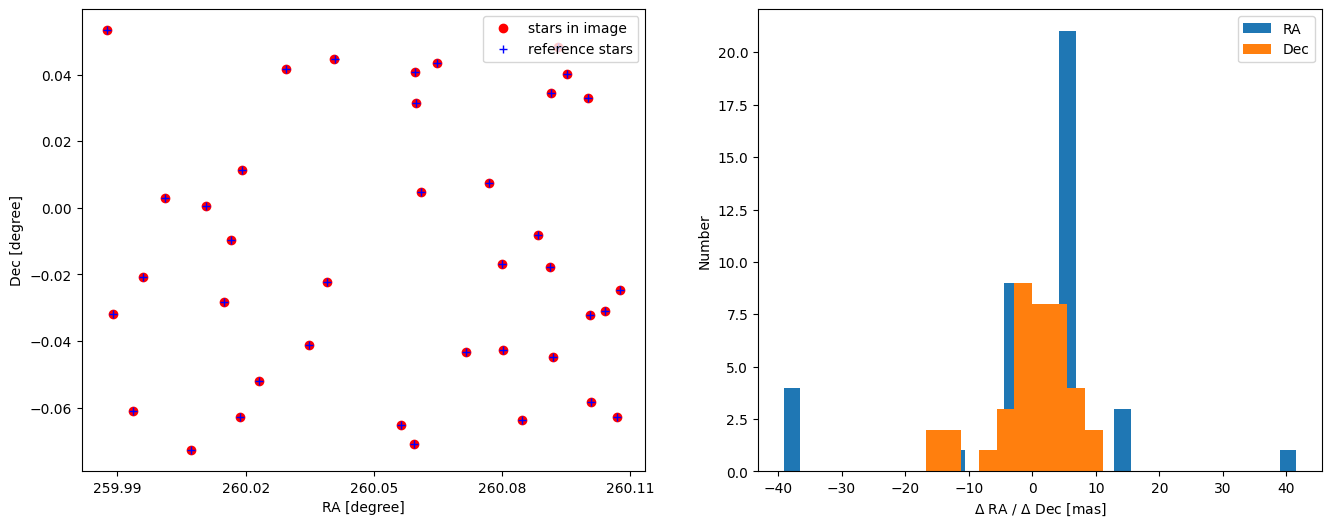

In [34]:
# fig, axes = plt.subplots(1, 1, figsize= (6, 6))
# from matplotlib.ticker import MaxNLocator

# # axes.plot(match_radec[0], match_radec[1], 'o', c='red', label="stars in image")
# axes.plot(match_radec[0], match_radec[1], 'o', c='red', label="stars in image")
# axes.plot(match_res_ra_gaia_uniqe, match_res_dec_gaia_uniqe, '+', c='blue', label="reference stars")
# axes.set_ylabel("Dec [degree]")
# axes.set_xlabel("RA [degree]")
# axes.xaxis.set_major_locator(MaxNLocator(5))
# axes.legend(loc=1)
fig, axes = plt.subplots(1, 2, figsize= (16, 6))
from matplotlib.ticker import MaxNLocator
# axes[0].plot(match_radec[0], match_radec[1], '.', c='red')
# axes[1].plot(match_res_ra_gaia_uniqe, match_res_dec_gaia_uniqe, '.', c='blue')

axes[0].plot(match_radec[0], match_radec[1], 'o', c='red', label="stars in image")
axes[0].plot(match_res_ra_gaia_uniqe, match_res_dec_gaia_uniqe, '+', c='blue', label="reference stars")
axes[0].set_ylabel("Dec [degree]")
axes[0].set_xlabel("RA [degree]")
axes[0].xaxis.set_major_locator(MaxNLocator(5))
axes[0].legend(loc=1)


axes[1].hist((match_radec[0] - match_res_ra_gaia_uniqe) * 3600000 * np.mean(np.cos(match_res_dec_gaia_uniqe / 180 * np.pi)), label="RA", bins=10, rwidth=0.3)
axes[1].hist((match_radec[1] - match_res_dec_gaia_uniqe) * 3600000, label="Dec", bins=10, rwidth=1)
axes[1].set_xlabel(r"$\Delta$ RA / $\Delta$ Dec [mas]")
axes[1].set_ylabel("Number")
axes[1].legend(loc=1)

In [35]:
match_x

array([3751.82783812,  549.48372257, 4877.10230001, 1226.72620266,
       3545.5591543 , 5003.23447685, 8096.17338467, 1192.5023374 ,
       3495.70623895, 2280.22374529,  952.21391765, 3527.47839892,
        317.61656325, 6146.55159155, 2060.46870049,  571.36107647,
       1713.71874899,  126.09674773, 6469.84606277, 1239.29137217,
       3152.47269949, 8608.53592706,   73.01940998, 5313.88068242,
       5696.15062743, 6436.39022557, 6615.65804235, 6744.57780754,
       7290.14486654, 7040.86237626,  600.68631497, 8705.06058516,
       2042.98426212, 2660.31673554, 3418.50153761, 1119.54651211,
       1452.81048197, 8278.10419088, 7733.96154812])

## 更新底片模型

### 全体星应用初步模型

In [36]:
sext_flags = sext_out_filter[:]["FLAGS"]
sext_out_x = sext_out_filter[:]["X_IMAGE"][sext_flags == 0]
sext_out_y = sext_out_filter[:]["Y_IMAGE"][sext_flags == 0]

sext_out_xieta = function.use_plate_model(sext_out_x - x_ref, sext_out_y - y_ref, A_CD_PRE, cof_xy)
sext_out_radec = function.ideal_cel_coord(sext_out_xieta[0], sext_out_xieta[1], pointing_ra, pointing_dec)

sext_out_ra = sext_out_radec[0]
sext_out_dec = sext_out_radec[1]

### 全体星天球位置匹配

In [37]:
refcat_lib_all = pd.DataFrame({"RA_ICRS": refcat_ra_now, "DE_ICRS": refcat_dec_now, "magg": ref_filter["magg"], "magr": ref_filter["magr"], "magi": ref_filter["magi"], "pos_x": ref_filter["Pos_X"], "pos_y": ref_filter["Pos_Y"]})
side_threshold = 0.00001

match_res_all = []

for i in range(len(sext_out_ra)):
    temp_lib = np.array([sext_out_ra[i], sext_out_dec[i]])
    index = np.sum(np.abs(refcat_lib_all.iloc[:, 0:2] - temp_lib) < side_threshold, axis=1) == 2
    if np.sum(index) == 1:
        match_res_all.append(np.hstack((np.array(temp_lib), int(i), refcat_lib_all.iloc[np.where(index == True)[0][0]])))

match_res_all = np.array(match_res_all)

### 计算更新的底片模型

In [38]:
match_res_xi_gaia_all, match_res_eta_gaia_all = function.cel_ideal_coord(match_res_all[:, 3], match_res_all[:, 4], pointing_ra, pointing_dec)
Y_xi = match_res_xi_gaia_all
Y_eta = match_res_eta_gaia_all

match_res_x_sext_all = np.zeros_like(match_res_xi_gaia_all)
match_res_y_sext_all = np.zeros_like(match_res_xi_gaia_all)

for index, i in enumerate(match_res_all[:, 2]):
    match_res_x_sext_all[index] = sext_out_x[int(i)]
    match_res_y_sext_all[index] = sext_out_y[int(i)]

match_x = match_res_x_sext_all
match_y = match_res_y_sext_all
match_mag = match_res_all[:, band_index + 4]


print("the matched stars", len(match_x))

# cof = int(np.floor((np.sqrt(8 * len(match_x) + 1) - 3) / 2))
cof_xy = 1
cof_mag = 4

A_CD = function.cal_plate_model_mag(match_x - x_ref, match_y - y_ref, match_mag, Y_xi, Y_eta, cof_xy, cof_mag)
print(A_CD)

the matched stars 2426
[[ 1.62110353e-04 -2.42407875e-07  2.01325780e-12 -2.69847379e-05
   1.68537405e-06 -4.67376991e-08  4.85562828e-10]
 [ 1.56045481e-04  2.54503862e-13  2.42408771e-07 -2.61127436e-05
   1.63299087e-06 -4.53091539e-08  4.70733830e-10]]


### 再应用更新的底片模型

In [39]:
match_xieta = function.use_plate_model_mag(match_x - x_ref, match_y - y_ref, match_mag, A_CD, cof_xy, cof_mag)
match_radec = function.ideal_cel_coord(match_xieta[0], match_xieta[1], pointing_ra, pointing_dec)
gaia_radec = (match_res_all[:, 3], match_res_all[:, 4])
gaia_xieta = function.cel_ideal_coord(gaia_radec[0], gaia_radec[1], pointing_ra, pointing_dec)


# 残差
dis_xi = (match_xieta[0] - gaia_xieta[0])
dis_eta = (match_xieta[1] - gaia_xieta[1])
dis_ra = (match_radec[0] - match_res_all[:, 3]) * 3600000
dis_dec = (match_radec[1] - match_res_all[:, 4]) * 3600000

print(np.std(dis_ra), np.std(dis_dec), cof_xy, cof_mag)

4.250234072466946 4.07021065346082 1 4


In [40]:
# 保存
# cof_mag_orders = 4
# cof_xy = 4
# for cof_mag in np.arange(1, cof_mag_orders + 1):

#     A_CD_LOOP = function.cal_plate_model_mag(match_x - x_ref, match_y - y_ref, match_mag, Y_xi, Y_eta, cof_xy, cof_mag)

#     match_xieta = function.use_plate_model_mag(match_x - x_ref, match_y - y_ref, match_mag, A_CD_LOOP, cof_xy, cof_mag)
#     match_radec = function.ideal_cel_coord(match_xieta[0], match_xieta[1], pointing_ra, pointing_dec)
#     gaia_radec = (match_res_all[:, 3], match_res_all[:, 4])
#     gaia_xieta = function.cel_ideal_coord(gaia_radec[0], gaia_radec[1], pointing_ra, pointing_dec)

#     # 残差
#     dis_xi = (match_xieta[0] - gaia_xieta[0])
#     dis_eta = (match_xieta[1] - gaia_xieta[1])
#     dis_ra = (match_radec[0] - match_res_all[:, 3]) * 3600000
#     dis_dec = (match_radec[1] - match_res_all[:, 4]) * 3600000

#     match_res_pickle = pd.DataFrame({"X_IMAGE": match_x, "Y_IMAGE": match_y, "DIS_RA": dis_ra, "DIS_DEC": dis_dec, "DIS_XI": dis_xi, "DIS_ETA": dis_eta, "MAG": match_mag})

#     with open(f'match_res/match_{band_short}_{unkonw_index}_{exp_time}_{cof_xy}_{cof_mag}.pkl', 'wb') as f:
#         pickle.dump(match_res_pickle, f)

In [41]:
match_res_pickle = pd.DataFrame({"X_IMAGE": match_x, "Y_IMAGE": match_y, "DIS_RA": dis_ra, "DIS_DEC": dis_dec, "DIS_XI": dis_xi, "DIS_ETA": dis_eta, "MAG": match_mag})

with open(f'match_res/match_{band_short}_{unkonw_index}_{exp_time}_{cof_xy}_{cof_mag}.pkl', 'wb') as f:
    pickle.dump(match_res_pickle, f)

# 残差分析

## 残差图

### 网格化

In [42]:
# create bins
bins_num = 1
bins_x = np.linspace(0.5, 9216.5, bins_num + 1)
bins_y = np.linspace(0.5, 9232.5, bins_num + 1)

# bins' centers of all box
bin_centers_x = (bins_x[:-1] + bins_x[1:]) / 2
bin_centers_y = (bins_y[:-1] + bins_y[1:]) / 2
bin_centers = np.transpose([np.tile(bin_centers_x, len(bin_centers_y)), np.repeat(bin_centers_y, len(bin_centers_x))])

# calculate error
distort_sum_bins = np.zeros((bins_num, bins_num))
distort_sum_values_x = np.zeros((bins_num, bins_num))
distort_sum_values_y = np.zeros((bins_num, bins_num))

dis_res_xy = [np.vstack((match_x, match_y, dis_xi, dis_eta))]
[distort_sum_bins, distort_sum_values_x, distort_sum_values_y] = function.cal_distort_model(dis_res_xy, bins_x, bins_y, bins_num, distort_sum_bins, distort_sum_values_x, distort_sum_values_y)

distort_mean_values_x = np.divide(distort_sum_values_x, distort_sum_bins, out=np.zeros_like(distort_sum_values_x), where=distort_sum_bins != 0)
distort_mean_values_y = np.divide(distort_sum_values_y, distort_sum_bins, out=np.zeros_like(distort_sum_values_y), where=distort_sum_bins != 0)

# mag-distortion
bins_x_id, bins_y_id = function.match_box_id(match_x, match_y, bins_x, bins_y)

### 星等残差图

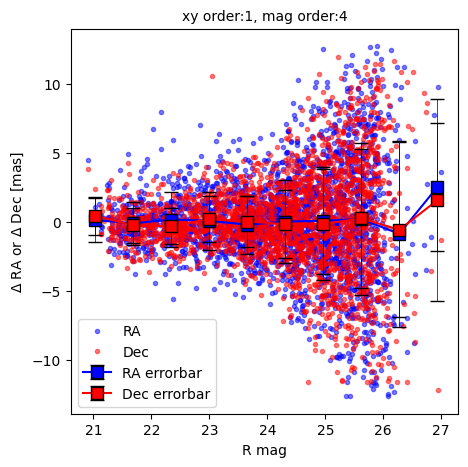

In [43]:
fig, axes = plt.subplots(bins_num, bins_num, figsize= (bins_num * 5, bins_num * 5))

for i in range(0, bins_num):
    for j in range(0, bins_num):

        # 各个区域画图
        index_box = (bins_x_id == i) & (bins_y_id == j)
        match_mag_box = match_mag[index_box]
        match_x_box = match_x[index_box]
        match_y_box = match_y[index_box]
        dis_ra_box = dis_ra[index_box]
        dis_dec_box = dis_dec[index_box]

        dis_ra_box, dis_dec_box, match_mag_box, filter = function.sigma_filter_2(dis_ra_box, dis_dec_box, match_mag_box, 3)
        index_mag = (match_mag_box < 29) & (match_mag_box > 15)

        dis_ra_box = dis_ra_box[index_mag]
        dis_dec_box = dis_dec_box[index_mag]
        match_mag_box = match_mag_box[index_mag]

        bins_divide_num = 10
        bin_centers_mag_box, bins_mean_dis_ra_box, bins_std_dis_ra_box = bins_divide(match_mag_box, dis_ra_box, bins_divide_num)
        bin_centers_mag_box, bins_mean_dis_dec_box, bins_std_dis_dec_box = bins_divide(match_mag_box, dis_dec_box, bins_divide_num)

        axe = axes if bins_num == 1 else axes[i][j]
        axe.plot(match_mag_box, dis_ra_box, '.', c='blue', label="RA", alpha = 0.5)
        axe.plot(match_mag_box, dis_dec_box, '.', c='red', label="Dec", alpha = 0.5)
        axe.errorbar(bin_centers_mag_box, bins_mean_dis_ra_box, yerr=bins_std_dis_ra_box, ecolor='k',elinewidth=0.5,marker='s',mfc='blue',mec='k',mew=1,ms=8,alpha=1,capsize=5,capthick=3,color="blue",label="RA errorbar")
        axe.errorbar(bin_centers_mag_box, bins_mean_dis_dec_box, yerr=bins_std_dis_dec_box, ecolor='k',elinewidth=0.5,marker='s',mfc='red',mec='k',mew=1,ms=8,alpha=1,capsize=5,capthick=3,color="red",label="Dec errorbar")

        axe.set_xlabel(f"{band_short_capital} mag")
        axe.set_ylabel(r"$\Delta$ RA or $\Delta$ Dec [mas]")
        axe.set_title(f"xy order:{cof_xy}, mag order:{cof_mag}", fontsize=10)
        axe.legend()

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


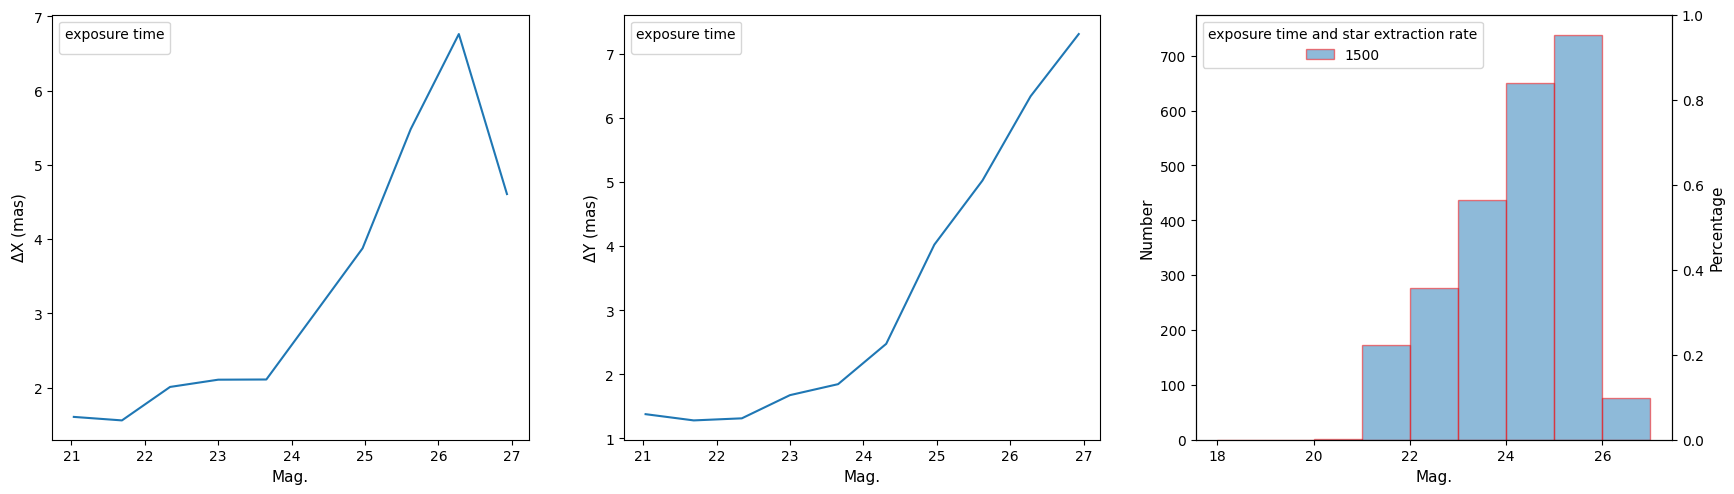

In [44]:
fig = plt.figure(num=1, figsize=(18, 5))
ax = fig.add_subplot(1, 3, 1)

plt.plot(bin_centers_mag_box, bins_std_dis_ra_box)
ax.set_xlabel(f'Mag.', fontsize=11)
ax.set_ylabel(r'$\Delta$X (mas)', fontsize=11)
plt.legend(loc='upper left', title='exposure time')

ax = fig.add_subplot(1, 3, 2)
plt.plot(bin_centers_mag_box, bins_std_dis_dec_box)

# ax.set_xlabel(f'{chr(ord(band) - 32)} Mag.', fontsize=11)
ax.set_xlabel(f'Mag.', fontsize=11)
ax.set_ylabel(r'$\Delta$Y (mas)', fontsize=11)
ax.legend(loc='upper left', title='exposure time')

ax = fig.add_subplot(1, 3, 3)
ax_twin = ax.twinx()
bin_edges = [18, 19, 20, 21, 22, 23, 24, 25, 26, 27]

num_bins, bins, _ = ax.hist(match_mag_box, bins=bin_edges, edgecolor="r", histtype="bar", alpha=0.5, label=exp_time)
# ax.set_xlabel(f'{chr(ord(band) - 32)} Mag.', fontsize=11)
ax.set_xlabel(f'Mag.', fontsize=11)
ax.set_ylabel('Number', fontsize=11)
ax.grid(False)
ax.legend(loc='upper left', title='exposure time and star extraction rate')

ax_twin.set_ylabel(r'Percentage', fontsize=11)
# custom_labels = np.round(np.arange(0, 250, 50) / num_stars * 100, 2)  # g
# custom_labels = np.round(np.arange(0, 800, 100) / num_stars, 2)  # i, r
# ax_twin.set_yticks(ticks=np.arange(0, 100, 100 / len(custom_labels)), labels=custom_labels)

ax_twin.grid(False)

plt.subplots_adjust(left=0.05, right=0.95, bottom=0.1, top=0.95)
plt.show()

### 位置残差图

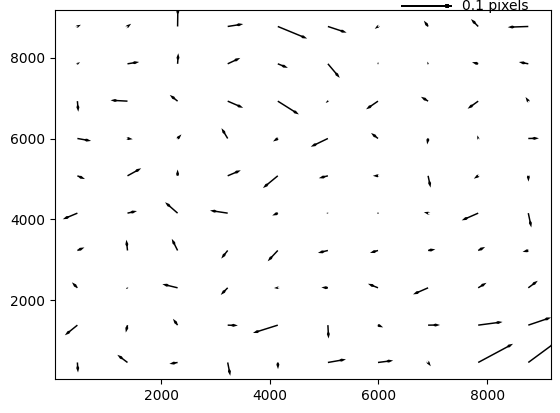

In [49]:
bins_num = 10
bins_x = np.linspace(0.5, 9216.5, bins_num + 1)
bins_y = np.linspace(0.5, 9232.5, bins_num + 1)

# bins' centers of all box
bin_centers_x = (bins_x[:-1] + bins_x[1:]) / 2
bin_centers_y = (bins_y[:-1] + bins_y[1:]) / 2
bin_centers = np.transpose([np.tile(bin_centers_x, len(bin_centers_y)), np.repeat(bin_centers_y, len(bin_centers_x))])

# calculate error
distort_sum_bins = np.zeros((bins_num, bins_num))
distort_sum_values_x = np.zeros((bins_num, bins_num))
distort_sum_values_y = np.zeros((bins_num, bins_num))

# dis_res_xy = [np.vstack((match_x, match_y, dis_ra, dis_dec))]
dis_res_xy = [np.vstack((match_x[filter][index_mag], match_y[filter][index_mag], dis_ra[filter][index_mag], dis_dec[filter][index_mag]))]
[distort_sum_bins, distort_sum_values_x, distort_sum_values_y] = function.cal_distort_model(dis_res_xy, bins_x, bins_y, bins_num, distort_sum_bins, distort_sum_values_x, distort_sum_values_y)

distort_mean_values_x = np.divide(distort_sum_values_x, distort_sum_bins, out=np.zeros_like(distort_sum_values_x), where=distort_sum_bins != 0)
distort_mean_values_y = np.divide(distort_sum_values_y, distort_sum_bins, out=np.zeros_like(distort_sum_values_y), where=distort_sum_bins != 0)

fig, axes = plt.subplots(1, 1)
quiver_scale = 9216
quiver_show_scale = 0.1
quiver = axes.quiver(bin_centers[:, 0], bin_centers[:, 1], distort_mean_values_x.flatten() / 50, distort_mean_values_y.flatten() / 50, scale=1 / quiver_scale, angles = 'xy', scale_units="xy", headwidth=2, headlength=3, width=0.003)
axes.quiverkey(quiver, 0.8, 1.01, quiver_show_scale, f"{quiver_show_scale} pixels",labelpos='E', coordinates='axes')

In [50]:
len(match_x[filter][index_mag])

2352

In [51]:
distort_sum_bins

array([[19., 15., 21., 21., 22., 20., 14., 19., 22., 23.],
       [24., 28., 31., 23., 15., 23., 31., 25., 22., 25.],
       [26., 19., 27., 30., 31., 30., 22., 19., 24., 22.],
       [26., 25., 24., 19., 26., 28., 23., 29., 32., 28.],
       [18., 23., 22., 27., 28., 19., 25., 22., 22., 22.],
       [29., 26., 27., 18., 23., 24., 19., 27., 15., 21.],
       [19., 25., 13., 24., 25., 17., 24., 27., 24., 25.],
       [26., 17., 23., 30., 18., 22., 27., 19., 23., 30.],
       [24., 30., 23., 29., 24., 28., 28., 26., 18., 18.],
       [15., 23., 23., 24., 19., 22., 30., 26., 27., 27.]])